In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from datetime import datetime

In [2]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [3]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]

img_noisyDataSet1 = np.expand_dims(img_noisyDataSet1, axis=-3)
img_noisyDataSet2 = np.expand_dims(img_noisyDataSet2, axis=-3)
img_groundTruth = np.expand_dims(img_groundTruth, axis=-3)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [4]:
# Acoto conjuntos (OPCIONAL)

img_noisyDataSet1 =img_noisyDataSet1[30:50,:,:,:]
img_noisyDataSet2 =img_noisyDataSet2[30:50,:,:,:]
img_groundTruth =img_groundTruth[30:50,:,:,:]

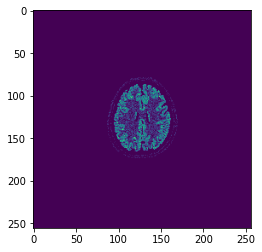

In [5]:
plt.imshow(img_noisyDataSet1[19,0,:,:])

In [5]:
# Error cuadratico medio entre dos imagenes

def MSE(img1, img2):
        cuadradoDeDif = ((img1 -img2) ** 2)
        suma = np.sum(cuadradoDeDif)
        cantPix = img1.shape[0] * img1.shape[1] 
        error = suma / cantPix
        return error

In [6]:
MSE_dataSet1_slice = MSE(img_noisyDataSet1[5,0,:,:],img_groundTruth[5,0,:,:])
print(MSE_dataSet1_slice)

0.35028509543889563


In [25]:
#Unet CLASICA

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.layer1Down = nn.Sequential (
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        
        self.layer2Down = nn.Sequential (
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size= 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        
        self.layer3Down = nn.Sequential (
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        
        self.layer4Down = nn.Sequential (
            torch.nn.Conv2d(128, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.layer5Down = nn.Sequential (
            torch.nn.Conv2d(256, 512, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
        )
        
        self.layer6Down = nn.Sequential (
            torch.nn.Conv2d(512, 1024, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1024, 1024, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
        )
        
        self.layer7Down = nn.Sequential (
            torch.nn.Conv2d(1024, 2048, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(2048),
            torch.nn.ReLU(),
            torch.nn.Conv2d(2048, 2048, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(2048),
            torch.nn.ReLU(),
        )
        
        self.Pooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Expand
        
        self.layer7ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(2048, 1024, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer6Up = nn.Sequential (
            torch.nn.Conv2d(2048, 1024, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1024, 1024, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
        )
        
        self.layer6ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer5Up = nn.Sequential (
            torch.nn.Conv2d(1024, 512, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
        )
        
        self.layer5ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer4Up = nn.Sequential (
            torch.nn.Conv2d(512, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.layer4ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer3Up = nn.Sequential (
            torch.nn.Conv2d(256, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        
        self.layer3ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer2Up = nn.Sequential (
            torch.nn.Conv2d(128, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        
        self.layer2ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer1Up = nn.Sequential (
            torch.nn.Conv2d(64, 32, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        
    
    def forward(self, x):

        # Down
        conv1 = self.layer1Down(x)
        maxPool1 = self.Pooling(conv1)
        
        
        conv2 = self.layer2Down(maxPool1)
        maxPool2 = self.Pooling(conv2)
        
        conv3 = self.layer3Down(maxPool2)
        maxPool3 = self.Pooling(conv3)
        
        conv4 = self.layer4Down(maxPool3)
        maxPool4 = self.Pooling(conv4)
        
        conv5 = self.layer5Down(maxPool4)
        maxPool5 = self.Pooling(conv5)
        
        conv6 = self.layer6Down(maxPool5)
        maxPool6 = self.Pooling(conv6)
        
        conv7 = self.layer7Down(maxPool6)
        

        # Up
        
        layerConvTransposed = self.layer7ConvTransposed(conv7)
        layer6UpData = torch.cat((layerConvTransposed,conv6), dim=1)
        convTrans6 = self.layer6Up(layer6UpData)
        
        layerConvTransposed = self.layer6ConvTransposed(convTrans6)
        layer5UpData = torch.cat((layerConvTransposed,conv5), dim=1)
        convTrans5 = self.layer5Up(layer5UpData)
        
        layerConvTransposed = self.layer5ConvTransposed(convTrans5)
        layer4UpData = torch.cat((layerConvTransposed,conv4), dim=1)
        convTrans4 = self.layer4Up(layer4UpData)        
 
        layerConvTransposed = self.layer4ConvTransposed(convTrans4)
        layer3UpData = torch.cat((layerConvTransposed,conv3), dim = 1)
        convTrans3 = self.layer3Up(layer3UpData)
        
        layerConvTransposed = self.layer3ConvTransposed(convTrans3)
        layer2UpData = torch.cat((layerConvTransposed,conv2), dim = 1)
        convTrans2 = self.layer2Up(layer2UpData)
        
        layerConvTransposed = self.layer2ConvTransposed(convTrans2)
        layer1UpData = torch.cat((layerConvTransposed,conv1), dim = 1)
        convTrans1 = self.layer1Up(layer1UpData)
        
        outNet = torch.nn.Conv2d(32,1, kernel_size = 1)(convTrans1)
        return outNet

unet = Unet()

In [64]:
# Resnet50 architecture + Unet

class UnetResnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.input = nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
        )
        
        self.Pooling = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # Contract
        self.layer1Down0 = nn.Sequential (
            torch.nn.Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
        )
        
        self.layer1Down1 = nn.Sequential (
            torch.nn.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
        )
        
        # Capa 2
        
        self.layer2Down0 = nn.Sequential (
            torch.nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
         
        )
            
        
        self.layer2Down1 = nn.Sequential (
            torch.nn.Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
        )
        
        self.middle = nn.Sequential(
            torch.nn.Conv2d(512, 512, padding=1, kernel_size=3, stride=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, padding=1, kernel_size=3, stride=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
        )
        
        # Up
        
        self.convTransposedlayer2 = nn.Sequential ( 
            torch.nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layerUp2 = nn.Sequential (
            torch.nn.Conv2d(512, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.convTransposedlayer1 = nn.Sequential ( 
            torch.nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layerUp1 = nn.Sequential (
            torch.nn.Conv2d(128+64, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        
        self.convTransposedlayer0 = nn.Sequential ( 
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layerUp0 = nn.Sequential (
            torch.nn.Conv2d(64+3, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        
        
        
    def forward(self, x):
        
        inputLayer = self.input(x)
        
        Pool = self.Pooling(inputLayer)
        
        # Down
        
        # Layer1
        layer1down0 = self.layer1Down0(Pool)
        layer1down1 = self.layer1Down1(layer1down0)
        layer1down2 = self.layer1Down1(layer1down1)
        
        # Layer 2
        layer2down0 = self.layer2Down0(layer1down2)
        layer2down1 = self.layer2Down1(layer2down0)
        layer2down2 = self.layer2Down1(layer2down1)
        layer2down3 = self.layer2Down1(layer2down2)
        
        # Middle
        middle = self.middle(layer2down3)

        # Up
        layerConvTrans = self.convTransposedlayer2(middle)
        layerUpData = torch.cat((layer1down2,layerConvTrans), dim=1)
        convTrans = self.layerUp2(layerUpData)
        
        layerConvTrans = self.convTransposedlayer1(convTrans)
        print(inputLayer.size())
        print(layerConvTrans.size())
        layerUpData = torch.cat((inputLayer,layerConvTrans), dim=1)
        convTrans = self.layerUp1(layerUpData)
        
        layerConvTrans = self.convTransposedlayer0(convTrans)
        layerUpData = torch.cat((x,layerConvTrans), dim=1)
        convTrans = self.layerUp0(layerUpData)
        

In [13]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unetResnet.parameters(), lr=0.0001)

# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,test_noisyImage,train_groundTruth,test_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.2)

valid_noisyImage = train_noisyImage[-5:,:,:,:]
valid_groundTruth = train_groundTruth[-5:,:,:,:]

train_noisyImage = train_noisyImage [:-5,:,:,:]
train_groundTruth = train_groundTruth[:-5:,:,:,:]
    

In [65]:
from torchsummary import summary

if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.stack((inputs,)*3, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unetResnet(inputs)


summary(unetResnet,inputs )

torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 128, 128])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                         [-1, 64, 128, 128]        --
├─MaxPool2d: 1-2                         [-1, 64, 64, 64]          --
├─Sequential: 1-3                        [-1, 256, 64, 64]         --
|    └─Conv2d: 2-4                       [-1, 64, 64, 64]          4,096
|    └─BatchNorm2d: 2-5                  [-1, 64, 64, 64]          128
|    └─Conv2d: 2-6                       [-1, 64, 64, 64]          36,864
|    └─BatchNorm2d: 2-7                  [-1, 64, 64, 64]          128
|    └─Conv2d: 2-8                       [-1, 256, 64, 64]         16,384
|    └─BatchNorm

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                         [-1, 64, 128, 128]        --
├─MaxPool2d: 1-2                         [-1, 64, 64, 64]          --
├─Sequential: 1-3                        [-1, 256, 64, 64]         --
|    └─Conv2d: 2-4                       [-1, 64, 64, 64]          4,096
|    └─BatchNorm2d: 2-5                  [-1, 64, 64, 64]          128
|    └─Conv2d: 2-6                       [-1, 64, 64, 64]          36,864
|    └─BatchNorm2d: 2-7                  [-1, 64, 64, 64]          128
|    └─Conv2d: 2-8                       [-1, 256, 64, 64]         16,384
|    └─BatchNorm2d: 2-9                  [-1, 256, 64, 64]         512
|    └─ReLU: 2-10                        [-1, 256, 64, 64]         

In [66]:
# Prueba con un slice 
if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.stack((inputs,)*3, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unetResnet(inputs)
    
gT = train_groundTruth[5]
gT = np.expand_dims(gT, axis=-3)
gT = torch.Tensor(gT)

inputs_np = inputs.detach().numpy()
out_np = out.detach().numpy()
gT_np = gT.detach().numpy()

MSE_orig = MSE(inputs_np[0,0,:,:],gT_np[0,0,:,:])
MSE_test = MSE(out_np[0,0,:,:],gT_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)


# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputs_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsNoTrain.nii')

img_out = sitk.GetImageFromArray(out_np[0,0,:,:])
sitk.WriteImage(img_out,'outNoTrain.nii')


img_gT = sitk.GetImageFromArray(gT_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthNoTrain.nii')

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 1, 256, 256] to have 3 channels, but got 1 channels instead

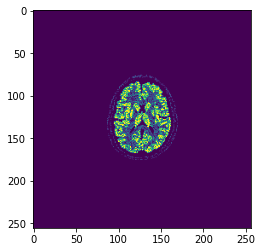

In [17]:
scaleForVisualization = 1.2*gT_np.max()

plt.imshow(inputs_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

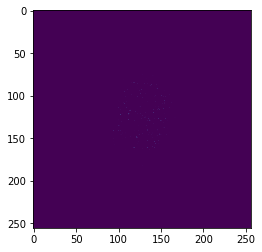

In [18]:
plt.imshow(out_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

In [25]:
# Codigo de pag Pythorch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i in range(0, train_noisyImage.shape[0]):
        
        # Acondicionamiento de datos
        
        inputs = train_noisyImage[i]
        inputs = np.expand_dims(inputs, axis=-3)
        inputs = torch.Tensor(inputs)
        
        trainGroundTruth = train_groundTruth[i]
        trainGroundTruth = np.expand_dims(trainGroundTruth, axis=-3)
        trainGroundTruth = torch.Tensor(trainGroundTruth)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, trainGroundTruth)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss en las ultimas 10 imagenes
            print('  image {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * ((train_noisyImage.shape[0])/10) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [26]:
# Initializing in a separate cell so we can easily add more epochs to the same run

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    unet.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    unet.train(False)

    running_vloss = 0.0
    for i in range(0, valid_noisyImage.shape[0]):
        
        vinputs = valid_noisyImage[i]
        vinputs = np.expand_dims(vinputs, axis=-3)
        vinputs = torch.Tensor(vinputs)
        
        validGroundTruth = valid_groundTruth[i]
        validGroundTruth = np.expand_dims(validGroundTruth, axis=-3)
        validGroundTruth = torch.Tensor(validGroundTruth)
        
        voutputs = unet(vinputs)
        vloss =  criterion(voutputs, validGroundTruth)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        unet_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(unet.state_dict(), unet_path)

    epoch_number += 1

EPOCH 1:
  image 10 loss: 2.133435535430908
LOSS train 2.133435535430908 valid 2.279911518096924
EPOCH 2:
  image 10 loss: 2.330241119861603
LOSS train 2.330241119861603 valid 2.3244426250457764
EPOCH 3:
  image 10 loss: 2.800252676010132
LOSS train 2.800252676010132 valid 2.391249418258667
EPOCH 4:
  image 10 loss: 2.426293045282364
LOSS train 2.426293045282364 valid 1.9165194034576416
EPOCH 5:
  image 10 loss: 2.5368021368980407
LOSS train 2.5368021368980407 valid 2.383298873901367
EPOCH 6:
  image 10 loss: 2.6609586000442507
LOSS train 2.6609586000442507 valid 2.1346211433410645
EPOCH 7:
  image 10 loss: 2.4073524475097656
LOSS train 2.4073524475097656 valid 1.980281114578247
EPOCH 8:
  image 10 loss: 2.1197468400001527
LOSS train 2.1197468400001527 valid 2.4232800006866455
EPOCH 9:
  image 10 loss: 2.616951322555542
LOSS train 2.616951322555542 valid 3.03532075881958
EPOCH 10:
  image 10 loss: 2.4153836607933044
LOSS train 2.4153836607933044 valid 2.9052958488464355


In [ ]:
plt.imshow(inputsTrain_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

In [ ]:
plt.imshow(outTrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

In [ ]:
plt.imshow(gTtrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

In [ ]:
# CONJUNTO DE TESTEO

if __name__ == '__main__':
    inputsTest = test_noisyImage[1]
    inputsTest = np.expand_dims(inputsTest, axis=-3)
    inputsTest = torch.Tensor(inputsTest)
    model = Unet()
    outTest = unet(inputsTest)
    
gTtest = test_groundTruth[1]
gTtest = np.expand_dims(gTtest, axis=-3)
gTtest = torch.Tensor(gTtest)

inputsTest_np = inputsTest.detach().numpy()
outTest_np = outTest.detach().numpy()
gTtest_np = gTtest.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTest_np[0,0,:,:],gTtest_np[0,0,:,:])
MSE_test = MSE(outTest_np[0,0,:,:],gTtest_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)

# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputsTest_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsTest.nii')

img_out = sitk.GetImageFromArray(outTest_np[0,0,:,:])
sitk.WriteImage(img_out,'outTest.nii')

img_gTtest = sitk.GetImageFromArray(gTtest_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthtest.nii')

In [ ]:
plt.imshow(inputsTest_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

In [ ]:
plt.imshow(outTest_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )